### 1. Reading Raw Data


In [3]:
import pandas as pd
import numpy as np
import os
import xgboost

%cd ..
#gdis data - geocoded disasters
gdis = pd.read_csv('data/disaster/pend-gdis-1960-2018-disasterlocations.csv')
# #emdat data - international disasters
emdat = pd.read_csv('data/disaster/emdat_public_2022_09_21_query_uid-47Yzpr.csv', skiprows=[0,1,2,3,4,5])

XGBoostError: 
XGBoost Library (libxgboost.dylib) could not be loaded.
Likely causes:
  * OpenMP runtime is not installed
    - vcomp140.dll or libgomp-1.dll for Windows
    - libomp.dylib for Mac OSX
    - libgomp.so for Linux and other UNIX-like OSes
    Mac OSX users: Run `brew install libomp` to install OpenMP runtime.

  * You are running 32-bit Python on a 64-bit OS

Error message(s): ["dlopen(/Users/cz938/Library/CloudStorage/Box-Box/NYUAD/Research/mml_flood/.venv/lib/python3.12/site-packages/xgboost/lib/libxgboost.dylib, 0x0006): Library not loaded: @rpath/libomp.dylib\n  Referenced from: <BBC4A126-D15A-3802-AD26-108872BA781A> /Users/cz938/Library/CloudStorage/Box-Box/NYUAD/Research/mml_flood/.venv/lib/python3.12/site-packages/xgboost/lib/libxgboost.dylib\n  Reason: tried: '/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file)"]


In [2]:
#select certain columns from emdat and join with gdis
emdat['disasterno'] = emdat['Dis No'].str[:-4] #format disasterno to merge
cols = ['disasterno', 'Year', 'Event Name',
        'Start Year', 'Start Month', 'Start Day',
        'End Year', 'End Month','End Day',
        "Total Damages, Adjusted ('000 US$)"]

emdat = emdat[cols]

In [4]:
#join emdat and gdis
gdis = pd.merge(emdat, gdis, on = 'disasterno', how='right')

In [5]:
gdis = gdis.drop_duplicates(subset=['id'])
print('shape', gdis.shape)
gdis.head(5)

shape (9924, 27)


,disasterno,Year,Event Name,Start Year,Start Month,Start Day,End Year,End Month,End Day,"Total Damages, Adjusted ('000 US$)",...,level,adm1,adm2,adm3,location,historical,hist_country,disastertype,latitude,longitude
0,2009-0631,2009.0,NaN,2009.0,12.0,27.0,2010.0,1.0,8.0,NaN,...,3,Shkoder,Shkodres,Ana E Malit,Ana E Malit,0,NaN,flood,42.020948,19.418317
2,2001-0146,2001.0,NaN,2001.0,4.0,2.0,2001.0,4.0,9.0,NaN,...,3,Cunene,Cuanhama,Onjiva,Onjiva,0,NaN,flood,-17.093484,15.665758
3,2009-0092,2009.0,NaN,2009.0,3.0,1.0,2009.0,4.0,16.0,NaN,...,3,Cunene,Cuanhama,Evale,Evale,0,NaN,flood,-16.531533,15.773987
18,2010-0105,2010.0,NaN,2010.0,3.0,1.0,2010.0,3.0,17.0,NaN,...,3,Cunene,Cuanhama,Evale,Evale,0,NaN,flood,-16.531533,15.773987
20,1995-0082,1995.0,NaN,1995.0,5.0,15.0,1995.0,5.0,15.0,1422569.0,...,3,Chittagong,Noakhali,Hatiya,Hatiya,0,NaN,storm,22.291591,91.065456


In [6]:
gdis['lat_grid'] = np.digitize(np.array(gdis['latitude']),np.arange(-90,90,1))
gdis['lon_grid'] = np.digitize(np.array(gdis['longitude']),np.arange(-180,180,1))
#compute the grid pair id
gdis['grid_id'] = list(zip(gdis['lat_grid'],gdis['lon_grid']))

### 2. Construct X

In [25]:
#pivot function: change rows of info into tables
def pivot(df_in, id_col='disastertype', id_list=['Flood']):
    """
    Transform the input DataFrame by pivoting disaster-related information into separate columns.

    This function creates binary and aggregated columns for specified disaster types based on the input DataFrame.
    It initializes three new columns for each disaster type: a binary indicator, the total adjusted damages,
    and a count of occurrences.

    Parameters:
    df_in (pd.DataFrame): The input DataFrame containing disaster information, including the specified
                          disaster type and total damages.
    id_col (str): The name of the column in the input DataFrame that contains the disaster type information.
                   Defaults to 'disastertype'.
    id_list (list): A list of disaster types to pivot. Each type will create corresponding columns in the output
                    DataFrame. Defaults to ['Flood'].

    Returns:
    pd.DataFrame: A DataFrame with additional columns for each disaster type in the id_list, including:
                  - A binary indicator column for the presence of the disaster type (e.g., 'Flood_bin').
                  - A column for the total adjusted damages related to that disaster type (e.g., 'Flood_amt').
                  - A count column indicating the number of occurrences of the disaster type (e.g., 'Flood_ct').
    """
    df = df_in.reset_index(drop = True)
    for id in id_list:
        #initialize columns
        df[id+'_bin'] = 0
        df[id+'_amt'] = 0
        df[id+'_ct'] = 0
        df.loc[(df[id_col]==id), id+'_bin'] = 1
        df.loc[(df[id_col]==id), id+'_amt'] = df["Total Damages, Adjusted ('000 US$)"].astype(float)
        df.loc[(df[id_col]==id), id+'_ct'] = 1
    return df

In [26]:
id_list= gdis['disastertype'].unique().tolist()
print(id_list)
df_pivot= pivot(gdis, id_col = 'disastertype', id_list = id_list)
df_pivot

['flood', 'storm', 'earthquake', 'extreme temperature ', 'landslide', 'volcanic activity', 'drought', 'mass movement (dry)']


,disasterno,Year,Event Name,Start Year,Start Month,Start Day,End Year,End Month,End Day,"Total Damages, Adjusted ('000 US$)",...,landslide_ct,volcanic activity_bin,volcanic activity_amt,volcanic activity_ct,drought_bin,drought_amt,drought_ct,mass movement (dry)_bin,mass movement (dry)_amt,mass movement (dry)_ct
0,2009-0631,2009.0,NaN,2009.0,12.0,27.0,2010.0,1.0,8.0,NaN,...,0,0,0.0,0,0,0.0,0,0,0.0,0
1,2001-0146,2001.0,NaN,2001.0,4.0,2.0,2001.0,4.0,9.0,NaN,...,0,0,0.0,0,0,0.0,0,0,0.0,0
2,2009-0092,2009.0,NaN,2009.0,3.0,1.0,2009.0,4.0,16.0,NaN,...,0,0,0.0,0,0,0.0,0,0,0.0,0
3,2010-0105,2010.0,NaN,2010.0,3.0,1.0,2010.0,3.0,17.0,NaN,...,0,0,0.0,0,0,0.0,0,0,0.0,0
4,1995-0082,1995.0,NaN,1995.0,5.0,15.0,1995.0,5.0,15.0,1422569.0,...,0,0,0.0,0,0,0.0,0,0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9919,1960-0011,1960.0,Manam,1960.0,3.0,17.0,1960.0,3.0,17.0,NaN,...,0,1,NaN,1,0,0.0,0,0,0.0,0
9920,2009-9633,2009.0,NaN,2009.0,NaN,NaN,2010.0,NaN,NaN,NaN,...,0,0,0.0,0,1,NaN,1,0,0.0,0
9921,1990-9289,1990.0,NaN,1990.0,NaN,NaN,1990.0,NaN,NaN,NaN,...,0,0,0.0,0,1,NaN,1,0,0.0,0
9922,1969-9069,1969.0,NaN,1969.0,NaN,NaN,1971.0,NaN,NaN,73867.0,...,0,0,0.0,0,1,73867.0,1,0,0.0,0


In [27]:
#aggregate columns by year
def aggregate_yrly(df):
    """
    Aggregate yearly disaster-related data by grid ID and year.

    This function consolidates counts, amounts, and binary indicators of disaster events
    for each unique grid ID and year. It groups the input DataFrame by these identifiers
    and aggregates the relevant columns accordingly.

    Parameters:
    df (pd.DataFrame): The input DataFrame containing disaster data, including counts,
                       amounts, binary indicators, and additional metadata such as
                       latitude and longitude.

    Returns:
    pd.DataFrame: A DataFrame indexed by grid ID and year, containing the aggregated
                  values for:
                  - Counts (sum) of events (columns ending with '_ct').
                  - Amounts (sum) of total damages (columns ending with '_amt').
                  - Binary indicators (max) for the occurrence of events (columns ending with '_bin').
                  - Additional metadata (latitude, longitude, start and end dates) for each grid ID and year.
    """
    #aggregate count
    col_ct = [col for col in df.columns if '_ct' in col]
    df_ct = df.groupby(['grid_id', 'year'])[col_ct].agg('sum')

    # Aggregate amount
    col_amt = [col for col in df.columns if '_amt' in col]
    df_amt = df.groupby(['grid_id', 'year'])[col_amt].agg('sum')

    # Aggregate binary
    col_bin = [col for col in df.columns if '_bin' in col]
    df_bin = df.groupby(['grid_id', 'year'])[col_bin].agg('max')

    # Additional columns to include
    additional_cols = ['latitude', 'longitude', 'Start Year', 'Start Month', 'Start Day', 'End Year', 'End Month', 'End Day']

    # Select the additional columns and drop duplicates
    df_additional = df.groupby(['grid_id', 'year'])[additional_cols].first()

    # Join all the DataFrames
    df_final = pd.concat([df_amt, df_ct, df_bin, df_additional], axis=1)

    return df_final.reset_index()

# df_pivot.head(30)
df_yrly = aggregate_yrly(df_pivot)
# df_yrly.head(10)
df_yrly.shape


(8680, 34)

flood_ct
0           1032
1            983
2            361
3            190
4             81
Name: count, dtype: int64


array([[<Axes: title={'center': 'flood_ct'}>]], dtype=object)

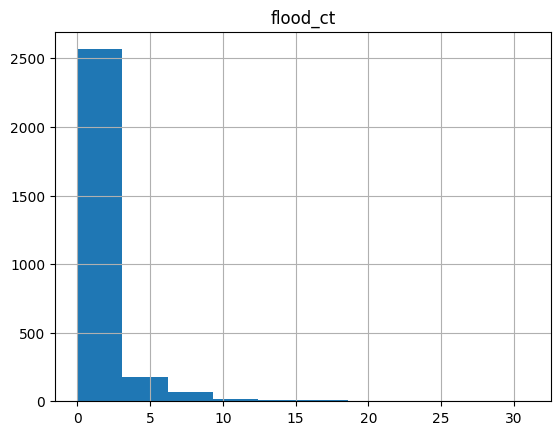

In [28]:
#count how many flood for each grid over all data
#sum grid id with total flood incidents
flood_ct = df_yrly.groupby('grid_id').agg({'flood_ct':'sum'})
print(flood_ct.value_counts().head(5))
flood_ct.hist() #[['grid_id','flood_ct']]

#1032 grids have no flood before, 983 have 1 flood only, 361 have 2 floods

### 3. Construct Y Master

In [29]:
bin_col =  [col for col in df_yrly.columns if '_bin' in col]
df_yrly_bin = df_yrly[['grid_id','year'] + bin_col]

In [30]:
# #get a list of disasters and flood_id
all_dis = gdis[['grid_id','Year','disastertype']]
flood = all_dis.loc[all_dis['disastertype']=='flood']
flood

,grid_id,Year,disastertype
0,"(133, 200)",2009.0,flood
2,"(73, 196)",2001.0,flood
3,"(74, 196)",2009.0,flood
18,"(74, 196)",2010.0,flood
27,"(113, 272)",2000.0,flood
...,...,...,...
82550,"(105, 90)",2018.0,flood
82732,"(114, 272)",1964.0,flood
82734,"(115, 272)",1966.0,flood
82735,"(104, 227)",1981.0,flood


In [31]:
# get a list of grid_ids
grid_id = gdis['grid_id'].unique()
# get a list of year information
print(gdis.Year.min(), gdis.Year.max())
year_id = np.arange(1960, 2019, 1)
#create multi-index: each grid id, spanning over the years
idd = pd.MultiIndex.from_product([grid_id, year_id],
                           names=['grid_id', 'year'])

#length should be |years| * |grid_ids|
print(len(idd))
#get dataframe
idd = idd.to_frame().reset_index(drop=True)

1960.0 2018.0
168268


In [32]:
#master disaster targets for all years and all ids:
#All historical flood events are captured for each location and year
#merge with df_yrly
y_master = pd.merge(idd, df_yrly_bin, on=['grid_id','year'], how='left').fillna(0)

In [33]:
#check:
print(y_master['flood_bin'].sum()) #total number of binary flood targets

#total number of flood incidents:
print(gdis.loc[gdis['disastertype']=='flood'].shape[0])

#the two numbers are slightly different, but that's because some country have more than 1 flood per year

4007.0
4274


### 4. Filter data to previously flooded regions

In [34]:
#step 1: filter xy_df to those grid_ids with previous frequent flooding history
agg = df_yrly.groupby('grid_id').agg({'flood_bin':'sum'})
grid_id_ls = agg.loc[agg['flood_bin']>=2].index.tolist()
print('no of grid_ids selected', len(grid_id_ls))


#step 2: interpolate years to record all years, fill with 0 without any flood using idd
#create multi-index: each grid id, spanning over the years
year_id = np.arange(1960, 2019, 1)
idd = pd.MultiIndex.from_product([grid_id_ls, year_id],
                           names=['grid_id', 'year'])

#length should be |years| * |grid_ids|
print('len of idd', len(idd))
#get dataframe
idd = idd.to_frame().reset_index(drop=True)

no of grid_ids selected 818
len of idd 48262


### 5. Attach NLP

In [35]:
import ast
from sklearn.model_selection import train_test_split


In [36]:
def to_tuple(df):
  '''
  grid_id is a string, convert to tuple if not already
  '''
  df['grid_id'] = df['grid_id'].apply(lambda t: t if type(t) == tuple else ast.literal_eval(t))
  return df

In [37]:
df_nlp_transfer = pd.read_csv('data/nlp/df_cls_transfer128.csv') ##128 transfer learning
df_nlp = to_tuple(df_nlp_transfer)

In [38]:
#attach target for a particular disaster for next n years, using y_master
def attach_target(x_df, y_master, disaster, next_n):
    """
    Attach a target binary indicator for a specific disaster type to the input DataFrame
    for the next 'n' years based on the provided master DataFrame.

    Parameters:
    x_df (pd.DataFrame): DataFrame containing input features with 'grid_id' and 'year'.
    y_master (pd.DataFrame): Master DataFrame containing disaster information with 'grid_id', 'year',
                             and disaster binary indicators.
    disaster (str): The specific disaster type to attach as a target (e.g., 'flood').
    next_n (int): The number of years in the future for which to shift the target indicator.

    Returns:
    pd.DataFrame: A new DataFrame that merges input features with the target disaster indicator,
                  aligned by 'grid_id' and the adjusted 'year'.
    """
    y = y_master.copy()
    #shift years
    y['year'] = y['year'] - next_n
    #keep for particular disaster
    y = y[['grid_id','year',disaster+'_bin']]
    y = y.rename(columns={disaster +'_bin': 'target_' + disaster + '_'+ str(next_n)})
    xy_df = pd.merge(x_df, y, on = ['grid_id','year'], how='inner')
    return xy_df


In [48]:
n_pred = 5
def combine_df(df_yrly, y_master, disaster_type, n_pred):
    """
    Combine yearly data with disaster target indicators

    Parameters:
    df_yrly (pd.DataFrame): DataFrame containing yearly data with 'grid_id' and 'year'.
    y_master (pd.DataFrame): Master DataFrame containing disaster indicators.
    disaster_type (str): The specific disaster type to analyze (e.g., 'flood').
    n_pred (int): The number of years into the future to consider for the target indicator.

    Returns:
    tuple: A tuple containing:
        - xy_df (pd.DataFrame): DataFrame with attached target indicators.
        - xy_df_sub (pd.DataFrame): Filtered DataFrame with relevant rows and columns for analysis.
    """
    # Attach targets to create xy_df
    xy_df = attach_target(df_yrly, y_master, disaster_type, n_pred)
    print('length of xy_df', len(xy_df))

    # Merge with idd as before
    xy_df_sub = xy_df.loc[xy_df['grid_id'].isin(grid_id_ls)]
    xy_df_sub = pd.merge(idd, xy_df_sub, on=['grid_id', 'year'], how='left').fillna(0)

    # relevant_columns = ['latitude', 'longitude', 'Start Year', 'Start Month', 'Start Day', 'End Year', 'End Month', 'End Day']
    # xy_df_sub = xy_df_sub[(xy_df_sub[relevant_columns] != 0).any(axis=1)]

    print('length of xy_df_sub', len(xy_df_sub))
    print('imbalance', xy_df_sub.filter(regex='target').sum() / len(xy_df_sub))

    return xy_df, xy_df_sub
xy_df, xy_df_sub = combine_df(df_yrly, y_master, 'flood', n_pred)

length of xy_df 7374
length of xy_df_sub 48262
imbalance target_flood_5    0.012308
dtype: float64


In [49]:
def combine_nlp(xy_df_sub, df_nlp):
    """
    Combine the DataFrame containing flood data with NLP features to create dataset
    for model training.

    Parameters:
    xy_df_sub (pd.DataFrame): DataFrame containing flood-related data.
    df_nlp (pd.DataFrame): DataFrame containing NLP features related to locations.

    Returns:
    tuple: A tuple containing:
        - xy_df_sub1 (pd.DataFrame): Merged DataFrame containing flood data and NLP features, includes only flood-relevant records.
        - without_extra_columns (pd.DataFrame): DataFrame without additional columns needed for extracting images.
        - x_train (pd.DataFrame): Training features DataFrame without target columns.
        - x_test (pd.DataFrame): Testing features DataFrame without target columns.
        - y_train (pd.DataFrame): Training target DataFrame containing only target columns.
        - y_test (pd.DataFrame): Testing target DataFrame containing only target columns.
    """
    xy_df_sub1 = pd.merge(xy_df_sub, df_nlp.drop(['location','txt'], axis=1), on=['grid_id'], how='left')
    without_extra_columns = xy_df_sub1.drop(['latitude', 'longitude', 'Start Year', 'Start Month', 'Start Day', 'End Year', 'End Month', 'End Day'], axis=1)
    x = without_extra_columns.drop(without_extra_columns.filter(regex='target').columns, axis=1)#drop target col
    x = x.select_dtypes(['number'])#drop index col
    y = without_extra_columns.filter(regex='target') #filter to cols containing target
    
    print('total feature n', xy_df_sub1.shape)
    return xy_df_sub1, without_extra_columns
xy_df_sub1, without_extra_columns = combine_nlp(xy_df_sub, df_nlp)

xy_df_sub1.to_csv('data/xy_df/xy_df_sub5.csv')

total feature n (48262, 166)


In [50]:
for ind, row in xy_df_sub1.iterrows():
	if row['grid_id'] == (89, 209):
		print(row['latitude'], row['longitude'])

0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0


In [44]:
(89, 209) in grid_id_ls

True